<a href="https://colab.research.google.com/github/AlinaZemlyakova/CompLing-2021-2022/blob/main/hw9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание № 9. Предобученные трансформеры 

### Задание 1 (8 баллов).
Дообучите 3 предобученных модели на тех же данных, что и в семинаре. Сравните качество и выберите лучшую. 
Модели должны отличаться друг от друга не только параметрами ru/en/multilingual, base/large, cased/uncased. Все три выбранные модели должны работать лучше, чем бейзлайн без дообучения (т.е. если модель не работает, попробуйте другую).

Записи с занятия: https://colab.research.google.com/drive/1f7bHv-GWNnLVEKlT3EcgmEhLTr21apMt#scrollTo=uB2EZn3Mnd25 




In [14]:
!pip install sklearn pandas matplotlib transformers
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from string import punctuation
import pandas as pd
import os, re
import random
from time import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import TFAutoModel, AutoTokenizer, AutoModelForMaskedLM
from transformers import pipeline

from tensorflow.keras.preprocessing.sequence import pad_sequences

%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/My Drive/lenta_sample.csv')
data.dropna(subset=['topic', 'text'], inplace=True)

In [10]:
def finetune (tokenizer, model):
  X = []

  # переводим тексты в последовательности индексов
  # У берта есть ограничение на максимальную длину последовательности - 512

  for text in data.title:
    ids = tokenizer.encode(text)
    X.append(ids[:512])
    
  X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

  id2label = {i:label for i, label in enumerate(set(data.topic.values))}
  label2id = {l:i for i, l in id2label.items()}

  y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

  train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

  X_train, y_train = X[train_index], y[train_index]
  X_valid, y_valid = X[valid_index], y[valid_index]

  input_word_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32,
                                     name="input_ids")
  
  output = model({"input_ids":input_word_ids})
  drop = tf.keras.layers.Dropout(0.3)(output[0][:, 0]) 
  dense = tf.keras.layers.Dense(y.shape[1], activation='softmax')(drop)

  model = tf.keras.Model(inputs=input_word_ids, outputs=dense)

  model.compile(tf.optimizers.Adam(learning_rate=2e-6,
                                    ), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', 
                           tf.keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])
  
  model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2,
          epochs=20)
  
  print(model.history.history.keys())
  plt.plot(model.history.history['accuracy'])
  plt.plot(model.history.history['val_accuracy'])
  plt.title('model rec_prec')
  plt.ylabel('rec_prec')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  pred = model.predict(X_valid, batch_size=5).argmax(1)

  print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

**Модель 1: russian-sensitive-topics**

In [5]:
tokenizer = AutoTokenizer.from_pretrained('Skoltech/russian-sensitive-topics')
model_skoltech = TFAutoModel.from_pretrained('Skoltech/russian-sensitive-topics')

Downloading:   0%|          | 0.00/524 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/18.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/680M [00:00<?, ?B/s]

Some layers from the model checkpoint at Skoltech/russian-sensitive-topics were not used when initializing TFBertModel: ['dropout_37', 'classifier']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at Skoltech/russian-sensitive-topics.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20
288/288 [==============================] - 101s 321ms/step - loss: 2.1647 - accuracy: 0.3715 - rec_prec: 0.0851 - val_loss: 0.9910 - val_accuracy: 0.7742 - val_rec_prec: 0.7419
Epoch 2/20
288/288 [==============================] - 90s 312ms/step - loss: 1.0354 - accuracy: 0.7118 - rec_prec: 0.6615 - val_loss: 0.6023 - val_accuracy: 0.8065 - val_rec_prec: 0.8387
Epoch 3/20
288/288 [==============================] - 90s 311ms/step - loss: 0.6719 - accuracy: 0.8281 - rec_prec: 0.8646 - val_loss: 0.4951 - val_accuracy: 0.8387 - val_rec_prec: 0.9032
Epoch 4/20
288/288 [==============================] - 90s 312ms/step - loss: 0.5363 - accuracy: 0.8472 - rec_prec: 0.8767 - val_loss: 0.4346 - val_accuracy: 0.8065 - val_rec_prec: 0.9355
Epoch 5/20
288/288 [==============================] - 90s 312ms/step - loss: 0.3511 - accuracy: 0.9132 - rec_prec: 0.9497 - val_loss: 0.4159 - val_accuracy: 0.8710 - val_rec_prec: 0.8710
Epoch 6/20
288/288 [==============================] - 90s 312ms/

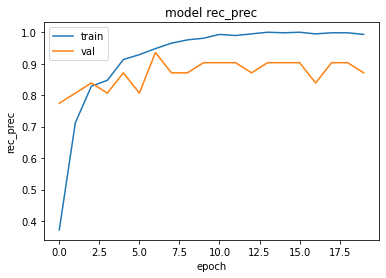

                   precision    recall  f1-score   support

              Мир       0.00      0.00      0.00         1
            Спорт       1.00      1.00      1.00         2
           Россия       1.00      0.50      0.67         2
        Экономика       1.00      1.00      1.00         2
         Из жизни       1.00      1.00      1.00         3
       Библиотека       0.00      0.00      0.00         0
         Ценности       1.00      1.00      1.00         2
  Наука и техника       1.00      1.00      1.00         3
Силовые структуры       0.67      1.00      0.80         2
           Бизнес       1.00      1.00      1.00         2
   69-я параллель       0.00      0.00      0.00         1
             Крым       0.00      0.00      0.00         0
          Легпром       0.00      0.00      0.00         1
              Дом       1.00      1.00      1.00         2
         Культура       1.00      1.00      1.00         3
      Бывший СССР       0.75      1.00      0.86       

In [12]:
finetune(tokenizer, model_skoltech)

**Модель 2: bert-base-multilingual-uncased-sentiment**

In [29]:
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

model_multi = TFAutoModel.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/639M [00:00<?, ?B/s]

Some layers from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment were not used when initializing TFBertModel: ['dropout_37', 'classifier']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20
288/288 [==============================] - 96s 301ms/step - loss: 2.8428 - accuracy: 0.0712 - rec_prec: 0.0000e+00 - val_loss: 2.7522 - val_accuracy: 0.0323 - val_rec_prec: 0.0000e+00
Epoch 2/20
288/288 [==============================] - 86s 300ms/step - loss: 2.7805 - accuracy: 0.0868 - rec_prec: 0.0000e+00 - val_loss: 2.7183 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 3/20
288/288 [==============================] - 88s 306ms/step - loss: 2.7189 - accuracy: 0.1024 - rec_prec: 0.0000e+00 - val_loss: 2.6367 - val_accuracy: 0.1290 - val_rec_prec: 0.0000e+00
Epoch 4/20
288/288 [==============================] - 89s 309ms/step - loss: 2.5654 - accuracy: 0.1823 - rec_prec: 0.0069 - val_loss: 2.3445 - val_accuracy: 0.2581 - val_rec_prec: 0.0323
Epoch 5/20
288/288 [==============================] - 89s 308ms/step - loss: 2.2081 - accuracy: 0.3229 - rec_prec: 0.0434 - val_loss: 2.0111 - val_accuracy: 0.3548 - val_rec_prec: 0.0323
Epoch 6/20
288/288 [=====================

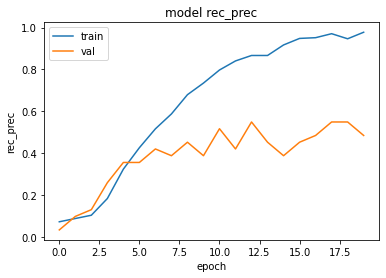

                   precision    recall  f1-score   support

              Мир       0.00      0.00      0.00         1
            Спорт       0.00      0.00      0.00         2
           Россия       0.00      0.00      0.00         2
        Экономика       0.00      0.00      0.00         2
         Из жизни       1.00      1.00      1.00         3
       Библиотека       0.00      0.00      0.00         0
         Ценности       1.00      0.50      0.67         2
  Наука и техника       0.50      0.67      0.57         3
Силовые структуры       0.00      0.00      0.00         2
           Бизнес       0.33      0.50      0.40         2
   69-я параллель       0.00      0.00      0.00         1
             Крым       0.00      0.00      0.00         0
          Легпром       1.00      1.00      1.00         1
              Дом       1.00      1.00      1.00         2
         Культура       0.67      0.67      0.67         3
      Бывший СССР       0.27      1.00      0.43       

In [30]:
finetune(tokenizer, model_multi)

**Модель 3: bert-base-ru-cased**

In [25]:
tokenizer = AutoTokenizer.from_pretrained("Geotrend/bert-base-ru-cased")
model_bert = TFAutoModel.from_pretrained("Geotrend/bert-base-ru-cased")

Some layers from the model checkpoint at Geotrend/bert-base-ru-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at Geotrend/bert-base-ru-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20
288/288 [==============================] - 95s 288ms/step - loss: 2.8855 - accuracy: 0.0729 - rec_prec: 0.0000e+00 - val_loss: 2.7202 - val_accuracy: 0.0645 - val_rec_prec: 0.0000e+00
Epoch 2/20
288/288 [==============================] - 80s 279ms/step - loss: 2.7914 - accuracy: 0.0764 - rec_prec: 0.0000e+00 - val_loss: 2.6597 - val_accuracy: 0.2903 - val_rec_prec: 0.0323
Epoch 3/20
288/288 [==============================] - 80s 279ms/step - loss: 2.6564 - accuracy: 0.1597 - rec_prec: 0.0069 - val_loss: 2.4857 - val_accuracy: 0.1613 - val_rec_prec: 0.0323
Epoch 4/20
288/288 [==============================] - 80s 279ms/step - loss: 2.3641 - accuracy: 0.2552 - rec_prec: 0.0087 - val_loss: 2.1311 - val_accuracy: 0.3871 - val_rec_prec: 0.0323
Epoch 5/20
288/288 [==============================] - 81s 281ms/step - loss: 2.0128 - accuracy: 0.3524 - rec_prec: 0.0694 - val_loss: 2.0045 - val_accuracy: 0.3871 - val_rec_prec: 0.1935
Epoch 6/20
288/288 [==============================] -

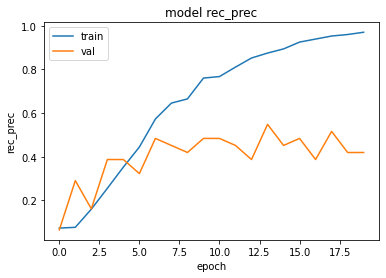

                   precision    recall  f1-score   support

              Мир       0.00      0.00      0.00         1
            Спорт       1.00      0.50      0.67         2
           Россия       0.00      0.00      0.00         2
        Экономика       1.00      0.50      0.67         2
         Из жизни       0.00      0.00      0.00         3
       Библиотека       0.00      0.00      0.00         0
         Ценности       0.40      1.00      0.57         2
  Наука и техника       0.50      0.33      0.40         3
Силовые структуры       0.00      0.00      0.00         2
           Бизнес       0.67      1.00      0.80         2
   69-я параллель       0.00      0.00      0.00         1
             Крым       0.00      0.00      0.00         0
          Легпром       0.00      0.00      0.00         1
              Дом       0.67      1.00      0.80         2
         Культура       0.50      0.67      0.57         3
      Бывший СССР       0.25      0.33      0.29       

In [26]:
finetune(tokenizer, model_bert)

**Итог**

Исходя из f1-меры и графиков accuracy лучшие результаты у модели от Skoltech russian-sensitive-topics, которая обучалась на наборе данных русского языка по различным деликатным темам. Возможно, тематики датасетов пересекаются, что объясняет высокое качество модели по сравнению с bert-base-ru-cased и bert-base-multilingual-uncased-sentiment.

### Задание  2 (2 балла)

Ответьте на следующие вопросы (напишите хотя бы по несколько предложений):

1) Чем ROBERTA отличается от BERT? В какой статье описана ROBERTA?

2) Чем модель T5 отличается от ROBERTA/BERT? 

**Ответы:**

1) RoBERTa описана в статье RoBERTa: A Robustly Optimized BERT Pretraining Approach: https://arxiv.org/pdf/1907.11692.pdf 

Базовая модель BERT имеет 12 слоев и 110 миллионов параметров с 768 слоями эмбеддингов, что делает ее очень сложной для обучения. Поэтому модель была оптимизирована в RoBERTa («надежно оптимизированный подход к обучению BERT». 

**Основные отличия:**

— у RoBERTa улучшенная методология обучения: чтобы улучшить процедуру обучения, RoBERTa удаляет задачу «Предсказание следующего предложения» (NSP) из предварительной подготовки BERT и вводит динамическое маскирование, чтобы замаскированный токен менялся в течение эпох обучения; 

— в RoBERTa больше данных: BERT предварительно обучен на 16 Гб данных из Toronto BookCorpus и английской википедии, RoBERTa помимо этих наборов также обучался на Common Crawl-News, Open WebText и т. д., в общей сложности на приблизительно 160 Гб данных.

— у RoBERTa большой размер батчей: чтобы повысить скорость и производительность модели, RoBERTa использует батч-сайз 8000 с 300000 шагов. Для сравнения, BERT использует батч-сайз 256 с 1 миллионом шагов.

— динамическое маскирование RoBERTa: BERT использует статическое маскирование, т. е. одна и та же часть предложения маскируется в каждую эпоху. Напротив, RoBERTa использует динамическую маскировку, при которой для разных эпох маскируются разные части предложений, что делает модель более надежной.

2) Модель Т5, предобученная на корпусе С4, показывает наилучшие результаты во многих NLP бенчмарках, обладая, при этом, достаточной гибкостью для тонкой настройки под конкретные задачи обработки текстов. 

Наряду с Т5 работает в формате text-to-text, где вход и выход модели представляются текстовыми строками, в отличие от моделей типа BERT, подающие на выход или метку класса, или фрагмент входной последовательности. Предложенный же фреймворк позволяет использовать одну и ту же модель, функцию потерь и гиперпараметры для любой задачи NLP, включая машинный перевод, суммаризацию документов, вопросно-ответные системы, задачу классификации (например, анализ тональности). Модель Т5 можно использовать даже для задачи регрессии, обучив ее предсказывать строковое представление числа вместо самого числа.